In [4]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

### Read org data

In [42]:
org_data = pd.read_parquet("../../data/data_agg_v0.parquet")
price_cols = ["PX_LAST"] + [f"PX_LAST_{x}" for x in range(2,13)]
term_structure_clean = org_data[price_cols]
term_structure_clean.index = org_data.Date
term_structure_clean = term_structure_clean.dropna()
term_structure_clean.shape

(5148, 12)

In [9]:
diff_pca = pd.read_csv("../../data/pca_5c.csv",index_col=0)
diff_pca.shape

(5148, 6)

In [11]:
diff_pca.describe()

,pca_0,pca_1,pca_2,pca_3,pca_4,contago
count,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5148.000000
mean,2.208369e-17,-4.692784e-17,-3.312554e-17,-1.725288e-17,3.692117e-17,0.387529
std,1.774044e+00,4.463481e-01,1.791163e-01,9.129343e-02,7.435930e-02,0.487233
min,-5.996729e+00,-2.435165e+00,-1.321276e+00,-6.836639e-01,-1.118002e+00,0.000000
25%,-1.293023e+00,-2.720380e-01,-9.376018e-02,-5.170620e-02,-1.330023e-02,0.000000
50%,1.876017e-01,-2.389563e-02,-1.695775e-02,-2.436623e-03,-2.860183e-04,0.000000
75%,1.109283e+00,2.674419e-01,9.062120e-02,4.631520e-02,1.231693e-02,1.000000
max,9.556162e+00,3.315659e+00,1.801641e+00,8.239062e-01,3.137150e+00,1.000000


Idea is to model them as HMM
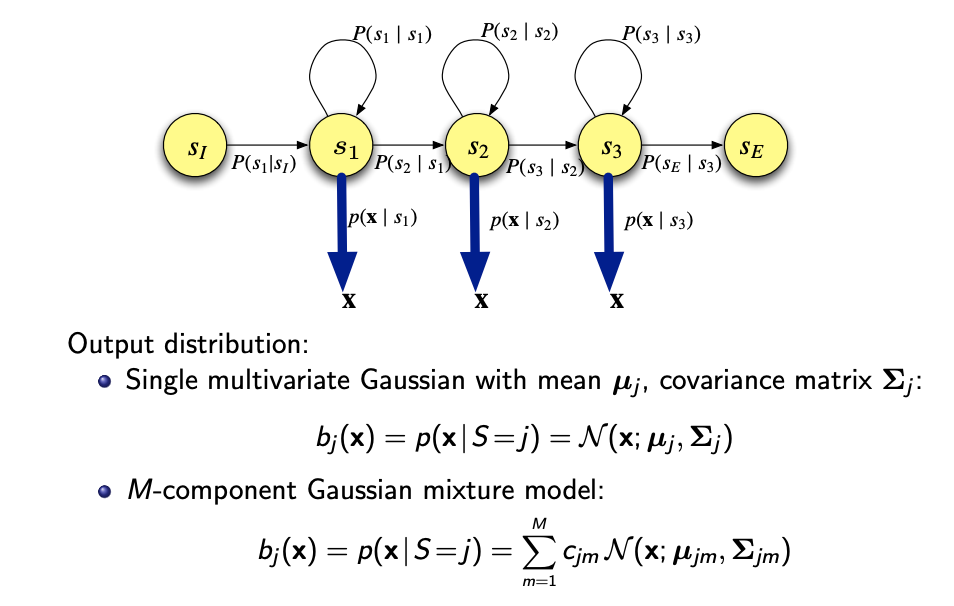

### Check if the PCA follows multivariate Normal

In [13]:
import seaborn as sns

<AxesSubplot: xlabel='pca_0', ylabel='pca_1'>

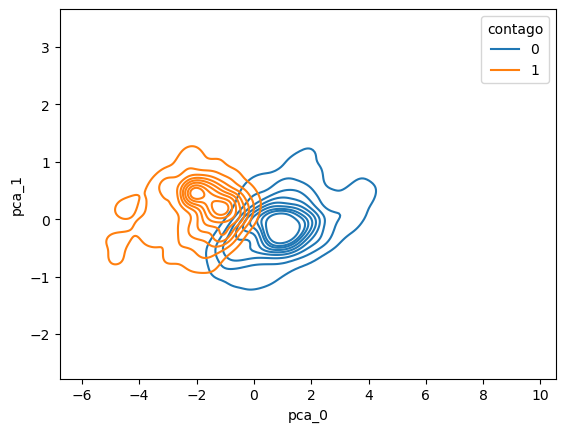

In [17]:
sns.kdeplot(x="pca_0",y="pca_1",hue="contago",data=diff_pca)

### HMM GMM

In [23]:
from hmmlearn.hmm import GMMHMM

In [43]:
hmm = GMMHMM(n_components=2,\
                 n_mix = 3, covariance_type="full")
X = diff_pca[["pca_0","pca_1"]]
X.shape

(5148, 2)

In [44]:
hmm.fit(X)

GMMHMM(covariance_type='full',
       covars_prior=array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]]),
       covars_weight=array([[-4., -4., -4.],
       [-4., -4., -4.]]),
       means_prior=array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]]),
       means_weight=array([[0., 0., 0.],
       [0., 0., 0.]]), n_components=2,
       n_mix=3, weights_prior=array([[1., 1., 1.],
       [1., 1., 1.]]))

In [45]:
hmm.transmat_

array([[0.99751469, 0.00248531],
       [0.00288651, 0.99711349]])

In [50]:
hmm.weights_

array([[0.56377242, 0.08704905, 0.34917853],
       [0.11788967, 0.46657136, 0.41553898]])

In [51]:
hmm.means_

array([[[ 0.98197878, -0.15288183],
        [ 3.89943192,  0.3682376 ],
        [ 1.19863887, -0.04028533]],

       [[-2.96821704, -0.12129754],
        [-1.45090261,  0.32069232],
        [-1.19661869, -0.13493926]]])

In [52]:
hmm.covars_

array([[[[ 0.26719502, -0.00737399],
         [-0.00737399,  0.04472483]],

        [[ 4.17714773,  0.80946593],
         [ 0.80946593,  1.01827226]],

        [[ 0.52545959,  0.07204449],
         [ 0.07204449,  0.16405822]]],


       [[[ 1.80569569,  0.37271933],
         [ 0.37271933,  0.42980687]],

        [[ 0.50334717, -0.09853624],
         [-0.09853624,  0.05841812]],

        [[ 0.42399951, -0.05812861],
         [-0.05812861,  0.1612623 ]]]])

In [55]:
diff_pca["hmm_contago"] = hmm.decode(X)[1]

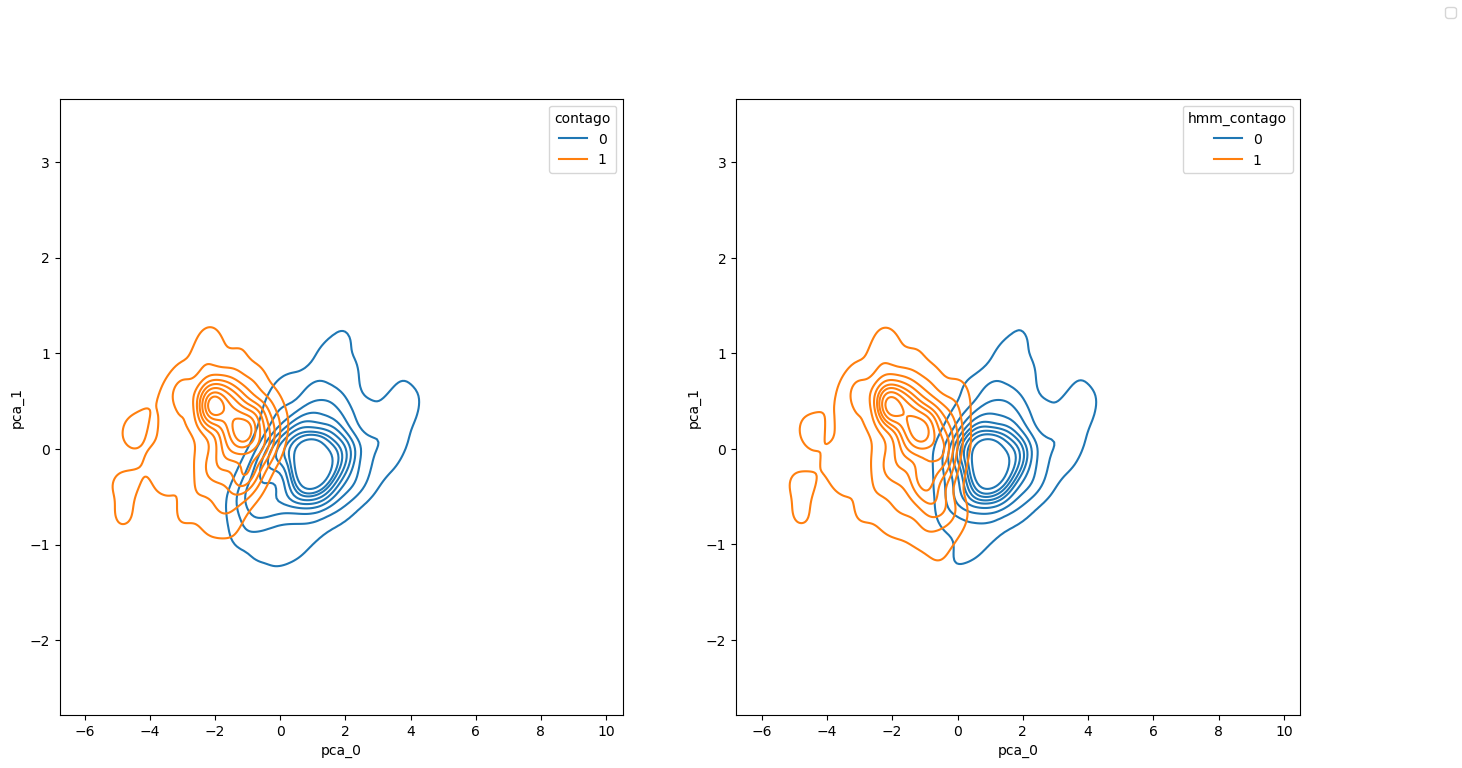

In [58]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
sns.kdeplot(x="pca_0",y="pca_1",hue="contago",ax=axs[0],data=diff_pca,label="Manual")
sns.kdeplot(x="pca_0",y="pca_1",hue="hmm_contago",ax=axs[1],data=diff_pca,label="HMM")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Map to real prices

In [60]:
term_structure_clean["hmm_contago"] = hmm.decode(X)[1]

In [62]:
monthly_avg = term_structure_clean.groupby(lambda x: (x.year, x.month)).mean()
monthly_avg

,PX_LAST,PX_LAST_2,PX_LAST_3,PX_LAST_4,PX_LAST_5,PX_LAST_6,PX_LAST_7,PX_LAST_8,PX_LAST_9,PX_LAST_10,PX_LAST_11,PX_LAST_12,hmm_contago
"(2003, 4)",24.535000,24.565833,24.543333,24.479167,24.392500,24.286667,24.167500,24.035833,23.905833,23.781667,23.664167,23.557500,0.0
"(2003, 5)",25.455000,25.217500,25.086000,24.966000,24.838500,24.690000,24.527500,24.351500,24.190000,24.034500,23.886000,23.741000,0.0
"(2003, 6)",27.288571,26.958095,26.676190,26.370952,26.048571,25.717143,25.389524,25.079524,24.778571,24.490952,24.212857,23.979048,0.0
"(2003, 7)",28.364348,28.191739,27.910435,27.562609,27.175652,26.798696,26.433478,26.076087,25.734783,25.424348,25.150000,24.893913,0.0
"(2003, 8)",29.443000,29.199500,28.890500,28.480000,28.036500,27.594500,27.154500,26.722500,26.300500,25.923000,25.633500,25.376000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2022, 12)",81.341429,81.687143,81.603333,81.448571,81.179524,80.883333,80.542381,80.183333,79.811905,79.452857,79.108571,78.752857,0.0
"(2023, 1)",83.997727,84.106818,83.940909,83.619545,83.234091,82.800455,82.351818,81.894545,81.452727,81.010455,80.560000,80.117273,0.0
"(2023, 2)",83.537500,83.223000,82.724000,82.299000,81.856500,81.416000,80.971500,80.537000,80.107000,79.665000,79.225000,78.834500,0.0
"(2023, 3)",79.206957,78.760435,78.506087,78.198261,77.856522,77.486087,77.130870,76.776087,76.415652,76.055652,75.733478,75.428696,0.0


In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [69]:
%matplotlib notebook

In [77]:
monthly_avg.iloc[0].index[:-1]

Index(['PX_LAST', 'PX_LAST_2', 'PX_LAST_3', 'PX_LAST_4', 'PX_LAST_5',
       'PX_LAST_6', 'PX_LAST_7', 'PX_LAST_8', 'PX_LAST_9', 'PX_LAST_10',
       'PX_LAST_11', 'PX_LAST_12'],
      dtype='object')

<IPython.core.display.Javascript object>


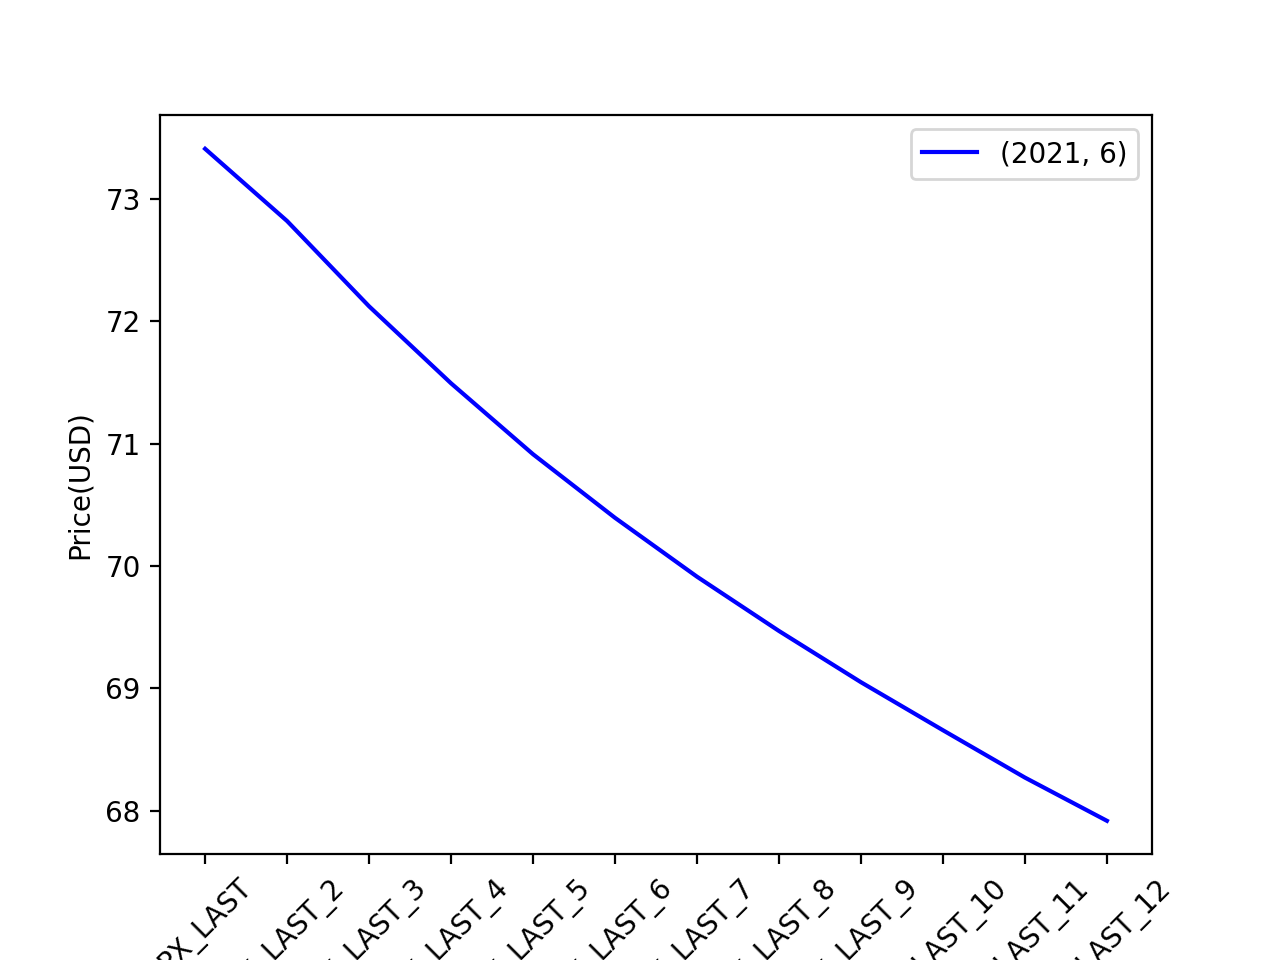

In [83]:
def animate(i):
    data = monthly_avg.iloc[i]
    x = data.index[:-1] # assigning 'Time' column to x variable
    y = data.values[:-1]
    color_i = "red" if data.values[-1] >0.33 else "blue"
    plt.cla() # clear axis after plotting individual lines
    plt.plot(x, y,color=color_i, label = monthly_avg.iloc[i].name) # selecting the x and y variables to plot
    plt.xticks(rotation = 45)
    plt.xlabel('Maturities') # label x axis
    plt.ylabel('Price(USD)') # label y axis
    plt.legend()
#     plt.title('HRR Graph')

ani = animation.FuncAnimation(plt.gcf(), animate, interval = 2, frames = 241, repeat = True)
plt.show()

In [84]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1000)
ani.save('term_str_animation_hmm.mp4', writer=writer)

In [12]:
contago1 = diff_pca.loc[diff_pca.contago>0]
contago0 = diff_pca.loc[diff_pca.contago==0]

In [3]:
df_agg = pd.read_parquet("../../data/data_agg_v0.parquet")

price_cols = [x for x in df_agg.columns if "LAST" in x]
df_subset = df_agg[["Date"] + price_cols[:12]]
df_subset.index = df_subset["Date"]
df_subset = df_subset.drop(columns=["Date"])
print(f"Shape before dropping nulls, {df_subset.shape}")
df_subset = df_subset.dropna()
print(f"Shape after dropping nulls, {df_subset.shape}")

Shape before dropping nulls, (5152, 12)
Shape after dropping nulls, (5148, 12)


In [ ]:
df_subset1 = df_subset.sort_index()

In [ ]:
mask1 = df_subset1["PX_LAST_6"]>df_subset1["PX_LAST"]
mask2 = df_subset1["PX_LAST_12"]>df_subset1["PX_LAST_6"]

df_subset1["contango"] = (mask1 & mask2).astype("int")
df_subset1["contango"].mean()

In [ ]:
contango = df_subset1[["contango"]]
for i in range(1,5):
    contango[f"lag_{i}"] = contango["contango"].shift(i)
contango["contango_start"] = ((contango.sum(axis=1)==1) & (contango["contango"]==1)).astype(int)

In [ ]:
contango["contango_start"].mean()

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))
df_subset1[df_subset1.contango>0].drop(columns="contango").groupby(lambda x: (x.year)).mean().T.plot(ax=ax)

In [ ]:
pca_data = pd.read_csv("../../data/log_returns_pca.csv",index_col=0)
pca_data.index = pd.to_datetime(pca_data.index)
pca_data.shape

In [ ]:
df_merged = df_subset1[["contango"]].merge(pca_data,left_index=True,right_index=True)
df_merged[[x for x in df_merged.columns if "pca" in x\
          ]] = df_merged[[x for x in df_merged.columns if "pca" in x]].shift(1)

In [ ]:
df_merged1 = df_merged.dropna()

import statsmodels.api as sm
Xtrain = df_merged1.values
y = df_merged1["contango"]

# building the model and fitting the data
log_reg = sm.Logit(y, Xtrain).fit()

In [ ]:
Xtrain.shape

In [ ]:
print(log_reg.summary())